# Apêndice A: Análise exploratória dos dados e criação das bases de dados do modelo ("Feature Engineering")

In [184]:
import pandas as pd
import openpyxl
import numpy as np
import os
import glob2
import glob
import random
import sklearn
import ntpath
import json
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from nltk.test.portuguese_en_fixt import setup_module
import nltk
from contextlib import nullcontext
import unicodedata
import plotly
import read_file_exec as rfe

O intuito desse anexo em Jupyter consiste em estudar os arquivos inputs e modelá-los para datasets a serem usados na aplicação de modelos matemáticos para predição de Vendas, para sugestão de estoque mínimo.


In [185]:
#Função para listar campos nulos de um dataframe e remover as colunas puramente nulas


def list_columns_and_remove_nullcontext(df):
    null_columns= []
    for column in df.columns:
        if df[column].isnull().all():
            null_columns = null_columns + [column]
    print(null_columns)
    df.drop(null_columns, axis=1, inplace=True)

In [186]:

def normalize_string(string):
        return ''.join(char for char in unicodedata.normalize('NFD', string) if unicodedata.category(char) != 'Mn')
    
def lower_string(string):
        return string.lower()

In [187]:
## Função para achar inconsistências em um dataframe
nat_as_integer = np.datetime64('NaT').view('i8')

def isnat(your_datetime):
    dtype_string = str(your_datetime.dtype)
    if 'datetime64[ns]' in dtype_string or 'timestamp64' in dtype_string:
        return your_datetime.view('i8') == nat_as_integer
    return False  # it can't be a NaT if it's not a dateime

#### Criação dos dataframes do modelo

In [188]:
dataframe_inventario = rfe.read_file('Files/Inventario.xlsx').get_df() # Cria dataframe de inventário ## Normaliza os nomes das colunas
dataframe_transacoes_produto = rfe.read_file('Files/Transações_por_produto.xlsx').get_df() #.prepare_columns() # Cria dataframe de transações por produto ## Normaliza os nomes das colunas
dataframe_transacoes_vendas = rfe.read_file('Files/Transações_vendas.xlsx').get_df()#.prepare_columns() # Cria dataframe de transações por venda ## Normaliza os nomes das colunas

In [189]:
dataframe_inventario.head()

,Descrição,Código,Estoque Atual,Estoque Reservado,Estoque Disponível,Preço,Categoria,Código Extra,Unidade,Fornecedor Principal,...,Comissão,Localização,Promoção,Data Inicial,Data Final,Preço Promocional,Status,Kit / Combo,EAN / GTIN,Exportar para balança
0,APLIQUE - APM4 -053 NOIVOS,7100692,9.0,0.0,9.0,2.5,PAPELARIA,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.893798e+12,Não
1,BARROCO MULT 200G -9384 GREENNERY,099810,0.0,0.0,0.0,22.8,Linha,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.891114e+12,Não
2,ABAJUR MARINHEIRO,124205,1.0,0.0,1.0,38.0,MDF,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4,ABRIDOR DE CASA G,7101086,2.0,0.0,2.0,5.0,ARMARINHO,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


In [190]:
dataframe_inventario.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Descrição              5261 non-null   object        
 1   Código                 5247 non-null   object        
 2   Estoque Atual          5247 non-null   float64       
 3   Estoque Reservado      5245 non-null   float64       
 4   Estoque Disponível     5244 non-null   float64       
 5   Preço                  5247 non-null   float64       
 6   Categoria              5234 non-null   object        
 7   Código Extra           0 non-null      float64       
 8   Unidade                557 non-null    object        
 9   Fornecedor Principal   2 non-null      object        
 10  Código Ref.            0 non-null      float64       
 11  Marca                  3921 non-null   object        
 12  Estoque Min.           5247 non-null   float64       
 13  Est

In [191]:
dataframe_transacoes_produto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47175 entries, 0 to 47174
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   NF                    0 non-null      float64       
 1   Ent                   0 non-null      float64       
 2   Tipo                  37170 non-null  object        
 3   Número                37170 non-null  float64       
 4   Data                  37170 non-null  datetime64[ns]
 5   Hora                  37170 non-null  datetime64[ns]
 6   Cliente / Fornecedor  2 non-null      object        
 7   Produto               47175 non-null  object        
 8   Quant.                47175 non-null  float64       
 9   Vl. Unitário          47175 non-null  float64       
 10  Sub-Total             47175 non-null  float64       
 11  Desconto              47175 non-null  float64       
 12  Outras Despesas       47175 non-null  int64         
 13  Total           

In [192]:
dataframe_transacoes_vendas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37170 entries, 0 to 37169
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Ent                   0 non-null      float64       
 1   Tipo                  37170 non-null  object        
 2   Número                37170 non-null  int64         
 3   Data                  37170 non-null  datetime64[ns]
 4   Hora                  37170 non-null  datetime64[ns]
 5   Cliente / Fornecedor  3 non-null      object        
 6   Itens                 37170 non-null  object        
 7   Total Final           37170 non-null  float64       
 8   Observações           32 non-null     object        
 9   Funcionário           37033 non-null  object        
 10  Vendedor              9479 non-null   object        
 11  Subtotal              9888 non-null   object        
 12  Desconto              37170 non-null  float64       
 13  Outras Despesas 

#### Checando o dataframe de transação

In [193]:
dataframe_transacoes_produto.head(15)

,NF,Ent,Tipo,Número,Data,Hora,Cliente / Fornecedor,Produto,Quant.,Vl. Unitário,Sub-Total,Desconto,Outras Despesas,Total,Funcionário,Valor Comissão,Comissão %,Calc.Comissão
0,NaN,NaN,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,NaN,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.00,0,6.97,Administrador,0,0,Sob.Total
1,NaN,NaN,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,NaN,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.00,0,28.00,Administrador,0,0,Sob.Total
2,NaN,NaN,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,NaN,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.00,0,5.80,Administrador,0,0,Sob.Total
3,NaN,NaN,NaN,NaN,NaT,NaT,NaN,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.00,0,3.00,Administrador,0,0,Sob.Total
4,NaN,NaN,NaN,NaN,NaT,NaT,NaN,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.00,0,3.00,Administrador,0,0,Sob.Total
5,NaN,NaN,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,MINIATURA LASER CADEIRA,-2.00,4.80,9.60,0.00,0,9.60,Administrador,0,0,Sob.Total
6,NaN,NaN,NaN,NaN,NaT,NaT,NaN,COLA TEK BOND 2 20G,-1.00,16.80,16.80,0.00,0,16.80,Administrador,0,0,Sob.Total
7,NaN,NaN,Venda,38247.0,2022-07-29 16:37:15.597,2022-07-29 16:37:15.597,NaN,AGULHA COSTURA -Darning MILWARD 5,-3.00,1.00,3.00,0.00,0,3.00,Administrador,0,0,Sob.Total
8,NaN,NaN,NaN,NaN,NaT,NaT,NaN,AGULHA COSTURA -Darning MILWARD 3,-2.00,1.00,2.00,0.00,0,2.00,Administrador,0,0,Sob.Total
9,NaN,NaN,NaN,NaN,NaT,NaT,NaN,AGULHA COSTURA -Darning N 1,-2.00,1.25,2.50,0.00,0,2.50,Administrador,0,0,Sob.Total


Como podemos ver, neste caso tivemos o arquivo agrupado no excel. O mesmo agrupamento não foi mantido na leitura, assim sendo necessário além da remoção de colunas nulas, uma função em que replique o último valor por cada tranação para que complete os dados que competem à mesma transação.

#### Checando o dataframe de inventário

In [194]:
dataframe_inventario.head()

,Descrição,Código,Estoque Atual,Estoque Reservado,Estoque Disponível,Preço,Categoria,Código Extra,Unidade,Fornecedor Principal,...,Comissão,Localização,Promoção,Data Inicial,Data Final,Preço Promocional,Status,Kit / Combo,EAN / GTIN,Exportar para balança
0,APLIQUE - APM4 -053 NOIVOS,7100692,9.0,0.0,9.0,2.5,PAPELARIA,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.893798e+12,Não
1,BARROCO MULT 200G -9384 GREENNERY,099810,0.0,0.0,0.0,22.8,Linha,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.891114e+12,Não
2,ABAJUR MARINHEIRO,124205,1.0,0.0,1.0,38.0,MDF,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4,ABRIDOR DE CASA G,7101086,2.0,0.0,2.0,5.0,ARMARINHO,NaN,NaN,NaN,...,NaN,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


Para os arquivos de inventário, é possível remover colunas puramente nulas, pois também, como no dataframe anterior, não agregarão ao modelo.

#### Limpeza e adequação dos dados: 


### Dataframe de Transações por produto

Neste caso, é interessante o uso do método de beforefill do pandas par que o registro posterior receba o valor do anterior, assim ajustando os agrupamentos do arquivo xlsx.

In [195]:
dataframe_transacoes_produto['tipo'] = dataframe_transacoes_produto['tipo'].fillna(method='bfill')
dataframe_transacoes_produto['numero'] = dataframe_transacoes_produto['numero'].fillna(method='bfill')
dataframe_transacoes_produto['data'] = dataframe_transacoes_produto['data'].fillna(method='bfill')
dataframe_transacoes_produto['hora'] = dataframe_transacoes_produto['hora'].fillna(method='bfill')

KeyError: 'tipo'

In [ ]:
dataframe_transacoes_produto_tratado = dataframe_transacoes_produto
dataframe_transacoes_produto_tratado.head()

,nf,ent,tipo,numero,data,hora,cliente___fornecedor,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,total,funcionario,valor_comissao,comissao__,calc_comissao
0,NaN,NaN,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,NaN,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.0,0,6.97,Administrador,0,0,Sob.Total
1,NaN,NaN,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,NaN,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.0,0,28.00,Administrador,0,0,Sob.Total
2,NaN,NaN,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,NaN,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.0,0,5.80,Administrador,0,0,Sob.Total
3,NaN,NaN,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total
4,NaN,NaN,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total


Neste passo para uma boa análise exploratória dos dados, é interessante remover colunas desinteressantes para o modelo. A função criada no início do modelo pode ser usada para a remoção de campos nulos de cada dataframe.

In [ ]:
list_columns_and_remove_nullcontext(dataframe_transacoes_produto_tratado)
dataframe_transacoes_produto_tratado.head()


['nf', 'ent']


,tipo,numero,data,hora,cliente___fornecedor,produto,quant_,vl__unitario,sub_total,desconto,outras_despesas,total,funcionario,valor_comissao,comissao__,calc_comissao
0,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,NaN,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.0,0,6.97,Administrador,0,0,Sob.Total
1,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,NaN,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.0,0,28.00,Administrador,0,0,Sob.Total
2,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,NaN,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.0,0,5.80,Administrador,0,0,Sob.Total
3,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total
4,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total


In [ ]:
dataframe_transacoes_produto_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47175 entries, 0 to 47174
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   tipo                  47175 non-null  object        
 1   numero                47175 non-null  float64       
 2   data                  47175 non-null  datetime64[ns]
 3   hora                  47175 non-null  datetime64[ns]
 4   cliente___fornecedor  2 non-null      object        
 5   produto               47175 non-null  object        
 6   quant_                47175 non-null  float64       
 7   vl__unitario          47175 non-null  float64       
 8   sub_total             47175 non-null  float64       
 9   desconto              47175 non-null  float64       
 10  outras_despesas       47175 non-null  int64         
 11  total                 47175 non-null  float64       
 12  funcionario           46952 non-null  object        
 13  valor_comissao  

Feito isso, um breve perfilamento dos dados trará informações para continuidade da limpeza dos dados, assim habilitando as explorações:

In [ ]:

dataframe_transacoes_produto_tratado.isnull().sum()


tipo                        0
numero                      0
data                        0
hora                        0
cliente___fornecedor    47173
produto                     0
quant_                      0
vl__unitario                0
sub_total                   0
desconto                    0
outras_despesas             0
total                       0
funcionario               223
valor_comissao              0
comissao__                  0
calc_comissao           27285
dtype: int64

Contabilizando valores nulos em cada coluna do dataframe de transações por produto:

In [ ]:
dataframe_transacoes_produto_tratado.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
numero,47175.0,20458.603922,10843.825850,1.00,11753.5,21035.0,29809.000,38253.0
quant_,47175.0,2.250551,125.751798,-10092.06,-1.0,-1.0,0.000,11988.0
vl__unitario,47175.0,6.850450,17.851295,0.00,0.0,2.5,9.375,1174.0
sub_total,47175.0,5.838035,14.485489,0.00,0.0,0.0,6.000,700.0
desconto,47175.0,0.159503,1.440226,0.00,0.0,0.0,0.000,98.0
outras_despesas,47175.0,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0
total,47175.0,5.678532,13.948205,0.00,0.0,0.0,6.000,700.0
valor_comissao,47175.0,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0
comissao__,47175.0,0.000000,0.000000,0.00,0.0,0.0,0.000,0.0



### Dataframe de Inventário

O mesmo tratamento de remoção de colunas puramente nulas será feito para o dataframe de inventário.

In [ ]:
dataframe_inventario_tratado = dataframe_inventario
list_columns_and_remove_nullcontext(dataframe_inventario_tratado)
dataframe_inventario_tratado.head()

['codigo_extra', 'codigo_ref_', 'pontos_nec_', 'tributacao', 'ncm', 'cest', 'peso_liq_', 'peso_bruto', 'comissao', 'localizacao']


,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
0,APLIQUE - APM4 -053 NOIVOS,7100692,9.0,0.0,9.0,2.5,PAPELARIA,NaN,NaN,LITOARTE,...,2021-04-13 15:15:27.708,admin,NAO,NaT,NaT,NaN,Ativo,Não,7.893798e+12,Não
1,BARROCO MULT 200G -9384 GREENNERY,099810,0.0,0.0,0.0,22.8,Linha,NaN,NaN,Círculo,...,2022-05-07 07:56:56.014,admin,NAO,NaT,NaT,NaN,Ativo,Não,7.891114e+12,Não
2,ABAJUR MARINHEIRO,124205,1.0,0.0,1.0,38.0,MDF,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,2022-02-08 09:41:08.406,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4,ABRIDOR DE CASA G,7101086,2.0,0.0,2.0,5.0,ARMARINHO,NaN,NaN,NaN,...,2021-10-11 09:35:33.641,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


In [ ]:
dataframe_inventario_tratado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5261 entries, 0 to 5260
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   descricao              5261 non-null   object        
 1   codigo                 5247 non-null   object        
 2   estoque_atual          5247 non-null   float64       
 3   estoque_reservado      5245 non-null   float64       
 4   estoque_disponivel     5244 non-null   float64       
 5   preco                  5247 non-null   float64       
 6   categoria              5234 non-null   object        
 7   unidade                557 non-null    object        
 8   fornecedor_principal   2 non-null      object        
 9   marca                  3921 non-null   object        
 10  estoque_min_           5247 non-null   float64       
 11  estoque_max_           5247 non-null   float64       
 12  abaixo_min_            5247 non-null   object        
 13  rep

In [ ]:
dataframe_inventario_tratado.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
estoque_atual,5247.0,1.745982e+01,1.462484e+02,-28.00,1.000000e+00,4.000000e+00,9.000000e+00,5.443000e+03
estoque_reservado,5245.0,0.000000e+00,0.000000e+00,0.00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
estoque_disponivel,5244.0,1.746981e+01,1.462896e+02,-28.00,1.000000e+00,4.000000e+00,9.000000e+00,5.443000e+03
preco,5247.0,1.515103e+01,3.116881e+01,0.06,3.500000e+00,6.800000e+00,1.980000e+01,7.500000e+02
estoque_min_,5247.0,1.905851e-03,1.380526e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+01
estoque_max_,5247.0,7.623404e-03,5.522102e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+01
repor,1.0,3.850000e+01,NaN,38.50,3.850000e+01,3.850000e+01,3.850000e+01,3.850000e+01
preco_promocional,2.0,1.600000e+01,0.000000e+00,16.00,1.600000e+01,1.600000e+01,1.600000e+01,1.600000e+01
ean___gtin,3630.0,7.840955e+12,2.283233e+12,3410394.00,7.891020e+12,7.891114e+12,7.893798e+12,6.789939e+13


In [ ]:
dataframe_inventario_tratado[dataframe_inventario_tratado['categoria'].isnull()]

,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,2022-02-08 09:41:08.406,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
7,PROMOÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
9,PROMOÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
11,PROMOÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
13,PROMOÇÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
403,ARGOLA CHAVEIRO SEM CORRENTE,8099803,-14.0,0.0,-14.0,0.3,NaN,NaN,NaN,NaN,...,2022-05-11 12:16:01.547,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
868,BOLSA CROCHÊ ALÇA BARROCO TARTARUGA,8099950,0.0,0.0,0.0,130.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
869,BOLSA CROCHÊ FIO DE MALHA P,8099950,1.0,0.0,1.0,60.0,NaN,NaN,NaN,NaN,...,2022-07-29 11:34:28.238,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
894,DE ALGODÃO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
975,LA SEDA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaT,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN


Neste caso temos alguns registros com código vazio. Estes serão desconsiderados do modelo. Repetiremos a análise de registros com categoria nula após a remoção dos citados para um enriquecimento destes casos já que são poucos.

In [ ]:
dataframe_inventario_tratado = dataframe_inventario[dataframe_inventario['codigo'].notnull()]

In [ ]:
dataframe_inventario_tratado[dataframe_inventario_tratado['codigo'].isnull()]

,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca


In [ ]:
dataframe_inventario_tratado[dataframe_inventario_tratado['categoria'].isnull()]

,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,NaN,NaN,NaN,NaN,...,2022-02-08 09:41:08.406,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
403,ARGOLA CHAVEIRO SEM CORRENTE,8099803,-14.0,0.0,-14.0,0.3,NaN,NaN,NaN,NaN,...,2022-05-11 12:16:01.547,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
868,BOLSA CROCHÊ ALÇA BARROCO TARTARUGA,8099950,0.0,0.0,0.0,130.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
869,BOLSA CROCHÊ FIO DE MALHA P,8099950,1.0,0.0,1.0,60.0,NaN,NaN,NaN,NaN,...,2022-07-29 11:34:28.238,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
1455,CX PORTA BARALHO,8099862,0.0,0.0,0.0,5.5,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
1493,DEDEIRA DE BORRACHA,8099737,9.0,0.0,9.0,2.0,NaN,UNDD,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3087,MDF VASO GRANDE,8099768,0.0,0.0,0.0,27.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3628,MOSQUETÃO CIRCULO PRATA,8099940,36.0,0.0,36.0,3.5,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,7.891113e+12,Não
3977,PASSA ELÁSTICO PINÇA,8099654,6.0,0.0,6.0,2.9,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4061,PLACA MDF DECORADA BEBE URSA,8099512,0.0,0.0,0.0,55.0,NaN,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


Tendo apenas 13 casos, é possível atribuir manualmente um valor de categoria como outros para os casos em que o código não foi informado, não sendo algo que enviesará o modelo, pois como visto, temos cerca de 5400 registros. Estes registros comporão não só inventário, mas serão fonte de cruzamento como uma dimensão que enriquecerá as transações com suas famílias de produtos (categoria).

In [ ]:
dataframe_inventario_tratado['categoria'] = dataframe_inventario_tratado['categoria'].fillna('Outros')

dataframe_inventario_tratado.head()


c:\Users\otavi\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


,descricao,codigo,estoque_atual,estoque_reservado,estoque_disponivel,preco,categoria,unidade,fornecedor_principal,marca,...,alterado_em,alterado_por,promocao,data_inicial,data_final,preco_promocional,status,kit___combo,ean___gtin,exportar_para_balanca
0,APLIQUE - APM4 -053 NOIVOS,7100692,9.0,0.0,9.0,2.5,PAPELARIA,NaN,NaN,LITOARTE,...,2021-04-13 15:15:27.708,admin,NAO,NaT,NaT,NaN,Ativo,Não,7.893798e+12,Não
1,BARROCO MULT 200G -9384 GREENNERY,099810,0.0,0.0,0.0,22.8,Linha,NaN,NaN,Círculo,...,2022-05-07 07:56:56.014,admin,NAO,NaT,NaT,NaN,Ativo,Não,7.891114e+12,Não
2,ABAJUR MARINHEIRO,124205,1.0,0.0,1.0,38.0,MDF,NaN,NaN,NaN,...,NaT,NaN,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
3,ABAJUR MDF DECORADO BEBE URSA,8099512,1.0,0.0,1.0,65.0,Outros,NaN,NaN,NaN,...,2022-02-08 09:41:08.406,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não
4,ABRIDOR DE CASA G,7101086,2.0,0.0,2.0,5.0,ARMARINHO,NaN,NaN,NaN,...,2021-10-11 09:35:33.641,admin,NAO,NaT,NaT,NaN,Ativo,Não,NaN,Não


In [ ]:
dataframe_inventario_tratado.isnull().sum()

descricao                   0
codigo                      0
estoque_atual               0
estoque_reservado           2
estoque_disponivel          3
preco                       0
categoria                   0
unidade                  4690
fornecedor_principal     5245
marca                    1326
estoque_min_                0
estoque_max_                0
abaixo_min_                 0
repor                    5246
premio__                    0
incluido_em                 0
alterado_em              1157
alterado_por             1157
promocao                    0
data_inicial             5245
data_final               5245
preco_promocional        5245
status                      0
kit___combo                 0
ean___gtin               1617
exportar_para_balanca       0
dtype: int64

In [ ]:
dataframe_inventario_tratado['categoria'].value_counts()

Linha         1639
ARMARINHO     1197
PAPELARIA     1123
LÃ             482
MDF            415
ENXOVAL        192
ARTESANATO     123
TECIDO          27
aviamento       23
Outros          13
LA              10
SERVIÇOS         1
Decoração        1
Roupas           1
Name: categoria, dtype: int64

In [ ]:
dataframe_inventario_tratado['categoria'] = dataframe_inventario_tratado['categoria'].apply(lambda x: normalize_string(x)).apply(lambda x: lower_string(x))
dataframe_inventario_tratado['categoria'].value_counts()

c:\Users\otavi\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


linha         1639
armarinho     1197
papelaria     1123
la             492
mdf            415
enxoval        192
artesanato     123
tecido          27
aviamento       23
outros          13
servicos         1
decoracao        1
roupas           1
Name: categoria, dtype: int64

Com os campos agora normalizados pelas funções presentes no na classe read_file normalize_string e lower_string, podemos tratar os dados de inventário para melhor contabilizá-los. Como o intuito desta parte é a melhoria e padronização dos dados, exploraremos os dados assim que tivermos um bom padrão para iniciar as análises.
O padrão deve seguir maneiras em que o dado há redução de ruídos de operação dos códigos de checagem para cruzamento dos dados com os dados de transação.


### Análises exploratórias dos dados

Iniciaremos a análise exploratória a partir dos dados de estoque trazendo alguns agrupamentos de dados que nos guiarão na análise.

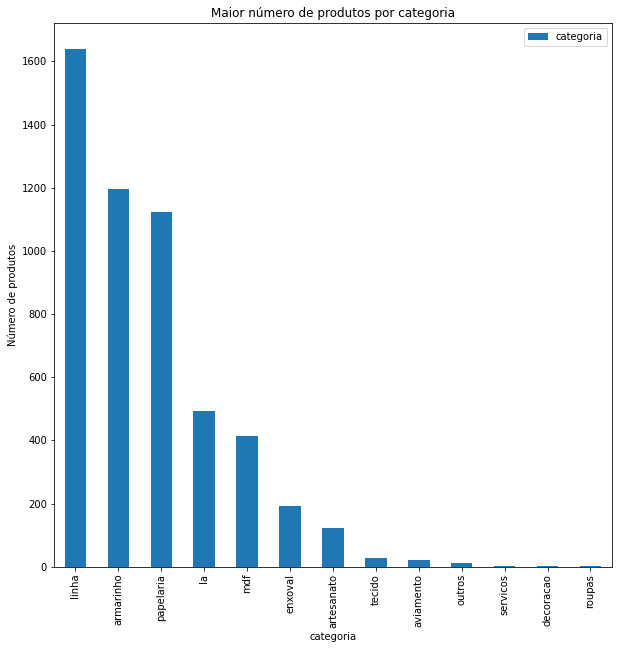

In [ ]:
plot_rank_categoria = dataframe_inventario_tratado['categoria'].value_counts().plot(kind='bar', title='Maior número de produtos por categoria',figsize=(10,10))
plot_rank_categoria.set_xlabel('categoria')
plot_rank_categoria.set_ylabel('Número de produtos')
plot_rank_categoria.legend(loc='upper right')
plt.show()


____________________________
| Categoria  |  Quantidade de produtos |
| ---------- | ---------:              |
|linha       |  1639                   |  
|armarinho   |  1197                   |  
|papelaria   |  1123                   |  
|la          |   492                   |  
|mdf         |   415                   |  
|enxoval     |   192                   |  
|artesanato  |   123                   |  
|tecido      |    27                   |  
|aviamento   |    23                   |  
|outros      |    13                   |  
|servicos    |     1                   |  
|decoracao   |     1                   |
|roupas      |     1                   |

Sendo assim, temos a ordem de maiores maiores granularidades de categorias de produto.

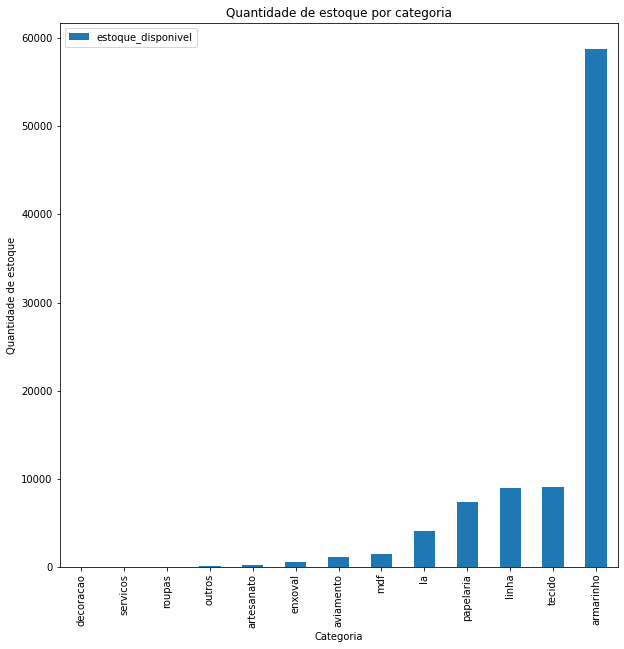

In [ ]:

from statistics import median


plot_rank_categoria_quantidade = dataframe_inventario_tratado['estoque_disponivel'].groupby(dataframe_inventario_tratado['categoria']).sum().sort_values().plot(kind='bar', title='Quantidade de estoque por categoria',
                                                                                                                figsize=(10,10))
plot_rank_categoria_quantidade.set_xlabel('Categoria') 
plot_rank_categoria_quantidade.set_ylabel('Quantidade de estoque')
plot_rank_categoria_quantidade.legend(loc='upper left')

plt.show()

Explorando as categorias que mais possuem estoque, sendo também as maiores em quantidade de produtos distintos, faremos um rank dos 10 primeiros produtos com maior quantidade de estoque presente.

In [137]:
plot_rank_categoria_quantidade_data = dataframe_inventario_tratado['estoque_disponivel'].groupby(dataframe_inventario_tratado['categoria']).sum().sort_values(ascending=False)
print("Primeira Alteração:{0} ".format(dataframe_inventario_tratado['alterado_em'].min()))
print("Última Alteração:{0} ".format(dataframe_inventario_tratado['alterado_em'].max()))
print(plot_rank_categoria_quantidade_data)


Primeira Alteração:2020-02-05 14:32:03.621000 
Última Alteração:2022-07-30 08:33:39.684000 
categoria
armarinho     58764.445
tecido         9050.890
linha          8899.000
papelaria      7395.190
la             4089.000
mdf            1426.000
aviamento      1124.650
enxoval         519.000
artesanato      234.000
outros          107.500
roupas            2.000
decoracao         0.000
servicos          0.000
Name: estoque_disponivel, dtype: float64


Com essa data de alteração do registro, é possível saber através do último registro presente que nos indica a data de extração do dado, podemos encontrar um fator
no qual representa a diferença entre a data de extração e a data de alteração do registro.
Consideraremos as datas de consideração de data de extração e data de inicio como primeiro registro de log de atividade.


In [138]:
data_extracao = dataframe_transacoes_produto_tratado['data'].max()
data_inicio = dataframe_transacoes_produto_tratado['data'].min()
diff = data_extracao - data_inicio
print("Data do estoque Inicial citado:{0} ".format(data_inicio))
print("Data do estoque presente citado:{0} ".format(data_extracao))
print("Delta:{0}".format(diff))

Data do estoque Inicial citado:2020-02-03 12:53:28.620000 
Data do estoque presente citado:2022-07-30 11:45:35.193000 
Delta:907 days 22:52:06.573000


Consideraremos dados que não possuam dada de inclusão como a data mínima de ínicio presente nos dados de transação utilizando a premissa de que seria um produto presente em estoque antes da implementação do ERP da loja.


Calcularemos uma taxa seguindo a seguinte variação:

* te_inicio_atualizacao = Delta temporal da data de inclusão até a data de extração presente do relatório
* te_atualizacao_presente = Delta temporal da data de alteração até a data de extração presente do relatório
* te_atualizacao_presente = Delta temporal da última atualização do código de inventário até a data de sua criação no sistema

Com isso, temos que:

* te_atualizacao_presente = te_inicio_presente
    fator_atualização = 0, sendo outlier como um novo produto em estoque
* te_atualizacao_presente > te_inicio_presente
    fator_atualização = (te_atualizacao_presente/te_inicio_presente)/100, nos dando um fator de última atualização
* te_inicio_presente <= 120
    fator_atualização = 0, sendo um produto recém incluso no estoque no último semestre

Nota: o "fator_atualizacao", portanto, no dará os itens mais parados em estoque tomando em conta este fator. Quanto mais próximo de 1, menos movimentado é o estoque. Isso não leva em conta seus preços. Esta heurística serve para nos guiar em termos de estoque sem analisar transações e suas tendências apenas para dar uma visão geral de itens que mais são movimentados (para mais ou para menos).

In [162]:
## ALTERADO VINICIUS
tempo_em_estoque = dataframe_inventario_tratado[['codigo','descricao','categoria','estoque_disponivel','preco','incluido_em','alterado_em']]
tempo_em_estoque['alterado_em'] = pd.to_datetime(tempo_em_estoque['alterado_em'])
 ## Caso não tenha data de inclusão, usa a premissa já existia no estoque
 ## Caso contrário, faz com as datas de inclusão e alteração

tempo_em_estoque_np = tempo_em_estoque['alterado_em'].to_numpy()
true_false_value_index = []
true_false_value_nat = []

for i in tempo_em_estoque_np:
    if isnat(i) == True:
        true_false_value_index.append(tempo_em_estoque['alterado_em'].index)
    true_false_value_nat.append(isnat(i))

        

for i in range(len(true_false_value_nat)):
    if true_false_value_nat[i] == True:
        aux = tempo_em_estoque['incluido_em'][true_false_value_index[0][i]]
        tempo_em_estoque['alterado_em'][true_false_value_index[0][i]] = aux
        
tempo_em_estoque.head(20) 

c:\Users\otavi\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
C:\Users\otavi\AppData\Local\Temp/ipykernel_564/3725119482.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tempo_em_estoque['alterado_em'][true_false_value_index[0][i]] = aux


,codigo,descricao,categoria,estoque_disponivel,preco,incluido_em,alterado_em
0,7100692,APLIQUE - APM4 -053 NOIVOS,papelaria,9.0,2.5,2020-11-16 17:19:42.000,2021-04-13 15:15:27.708
1,099810,BARROCO MULT 200G -9384 GREENNERY,linha,0.0,22.8,2020-03-09 10:00:50.269,2022-05-07 07:56:56.014
2,124205,ABAJUR MARINHEIRO,mdf,1.0,38.0,2020-08-07 15:58:36.302,2020-08-07 15:58:36.302
3,8099512,ABAJUR MDF DECORADO BEBE URSA,outros,1.0,65.0,2022-02-08 09:40:31.280,2022-02-08 09:41:08.406
4,7101086,ABRIDOR DE CASA G,armarinho,2.0,5.0,2021-01-26 15:42:06.736,2021-10-11 09:35:33.641
5,7100352,ABRIDOR DE CASA P,armarinho,7.0,2.5,2020-10-27 12:58:15.762,2021-10-11 09:35:54.698
6,7100369,ACRIPUFF - AMARELO OURO,papelaria,6.0,2.5,2020-10-27 15:05:06.788,2021-06-25 09:59:20.733
8,7100372,ACRIPUFF - BRANCO,papelaria,2.0,2.5,2020-10-27 15:42:30.541,2021-06-25 09:59:33.484
10,7100370,ACRIPUFF - PRETO,papelaria,4.0,2.5,2020-10-27 15:40:31.781,2021-06-25 09:59:57.732
12,7100371,ACRIPUFF - VERMELHO,papelaria,2.0,2.5,2020-10-27 15:41:18.222,2021-06-25 10:00:10.741


In [201]:
for index, row in tempo_em_estoque.iterrows():
        
        tempo_em_estoque.loc[index,'te_inicio_presente'] = (data_extracao - row['incluido_em']).days #Tempo total de estoque em dias do ínicio de inclusão até última atualização
        tempo_em_estoque.loc[index,'te_atualizacao_presente'] = (data_extracao - row['alterado_em']).days #Tempo total de estoque em dias do ínicio de inclusão até última atualização
        tempo_em_estoque.loc[index,'te_inicio_atualizacao'] = (row['alterado_em'] - row['incluido_em']).days #Tempo total de estoque em dias do ínicio de inclusão até última atualização
        if tempo_em_estoque.loc[index,'te_inicio_presente'] <= 90:
              tempo_em_estoque.loc[index,'clf_estoque'] = 'Produto alterado no último trimestre'
              try:
                      tempo_em_estoque.loc[index,'fator_atualizacao'] = 1 - (tempo_em_estoque.loc[index,'te_atualizacao_presente'] / tempo_em_estoque.loc[index,'te_inicio_presente'])
              except ZeroDivisionError:
                        tempo_em_estoque.loc[index,'fator_atualizacao'] == 0 
        elif tempo_em_estoque.loc[index,'te_inicio_presente'] > tempo_em_estoque.loc[index,'te_atualizacao_presente']:
                tempo_em_estoque.loc[index,'clf_estoque'] = 'Produto no estoque'
                tempo_em_estoque.loc[index,'fator_atualizacao'] = (tempo_em_estoque.loc[index,'te_atualizacao_presente']/tempo_em_estoque.loc[index,'te_inicio_presente'])
        else:
                tempo_em_estoque.loc[index,'clf_estoque'] = 'Risco de estoque parado'
                tempo_em_estoque.loc[index,'fator_atualizacao'] = 1   

     


tempo_em_estoque.head(50).sort_values(by=['fator_atualizacao'], ascending=False)

c:\Users\otavi\AppData\Local\Programs\Python\Python38\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,codigo,descricao,categoria,estoque_disponivel,preco,incluido_em,alterado_em,te_inicio_presente,te_atualizacao_presente,te_inicio_atualizacao,clf_estoque,fator_atualização,fator_atualizacao
2,124205,ABAJUR MARINHEIRO,mdf,1.0,38.00,2020-08-07 15:58:36.302,2020-08-07 15:58:36.302,721.0,721.0,0.0,Risco de estoque parado,1.000000,1.000000
3,8099512,ABAJUR MDF DECORADO BEBE URSA,outros,1.0,65.00,2022-02-08 09:40:31.280,2022-02-08 09:41:08.406,172.0,172.0,0.0,Risco de estoque parado,1.000000,1.000000
32,8099730,AGULHA CIRCULAR 60CM - 9MM,armarinho,6.0,25.00,2022-04-18 11:37:51.398,2022-04-18 11:37:51.398,103.0,103.0,0.0,Risco de estoque parado,1.000000,1.000000
17,7100576,ADESIVO PARA POTE - SABONETE ARTESANAL,papelaria,10.0,1.50,2020-11-12 13:51:52.113,2020-11-12 13:51:52.113,624.0,624.0,0.0,Risco de estoque parado,1.000000,1.000000
16,7100575,ADESIVO PARA POTE - FEITO A MÃO,papelaria,7.0,1.50,2020-11-12 13:51:03.043,2020-11-12 13:51:03.043,624.0,624.0,0.0,Risco de estoque parado,1.000000,1.000000
27,7101667,"AGULHA CIRCULAR 60CM - 4,5MM",armarinho,0.0,22.00,2021-09-30 12:31:11.454,2021-10-11 11:27:23.683,302.0,292.0,10.0,Produto no estoque,0.966887,0.966887
0,7100692,APLIQUE - APM4 -053 NOIVOS,papelaria,9.0,2.50,2020-11-16 17:19:42.000,2021-04-13 15:15:27.708,620.0,472.0,147.0,Produto no estoque,0.761290,0.761290
42,7101423,AGULHA COSTURA CIRCULO - 8,armarinho,28.0,0.50,2021-06-16 09:59:41.438,2021-10-11 13:07:13.583,409.0,291.0,117.0,Produto no estoque,0.711491,0.711491
28,7101396,AGULHA CIRCULAR 60CM - 4MM BAMBU,armarinho,0.0,22.00,2021-05-25 16:17:17.243,2021-10-11 11:29:23.394,430.0,292.0,138.0,Produto no estoque,0.679070,0.679070
12,7100371,ACRIPUFF - VERMELHO,papelaria,2.0,2.50,2020-10-27 15:41:18.222,2021-06-25 10:00:10.741,640.0,400.0,240.0,Produto no estoque,0.625000,0.625000


In [199]:
classificacao_inv = tempo_em_estoque.groupby('clf_estoque').agg({'categoria': 'nunique', 'codigo': 'count'})
classificacao_inv.head()

,categoria,codigo
clf_estoque,,
Produto alterado no último trimestre,11,224
Produto no estoque,9,3881
Risco de estoque parado,11,1142


In [200]:
for 
producto_por_clf = tempo_em_estoque[['clf_estoque','descricao','fator_atualizacao']].head(15).sort_values(by=['fator_atualizacao'], ascending=False)

KeyError: "[''] not in index"

<AxesSubplot:title={'center':'Classificação de produtos por estoque'}, xlabel='clf_estoque'>

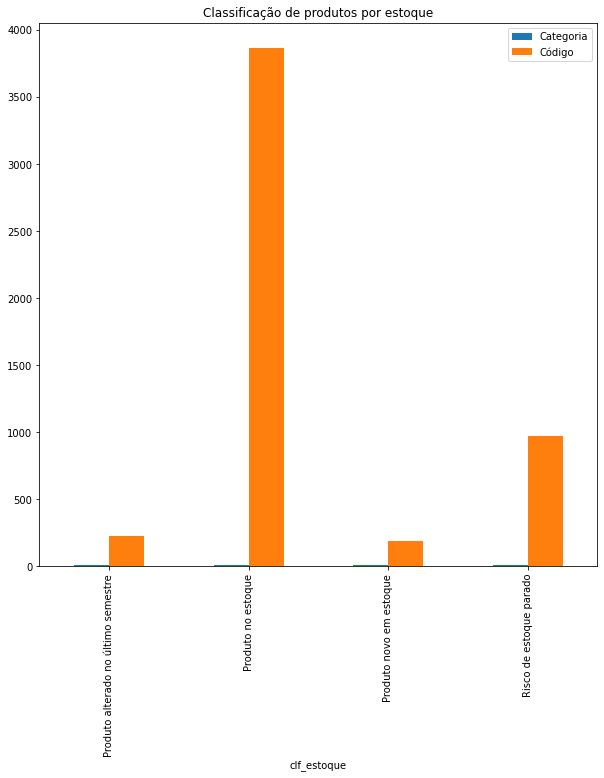

In [ ]:
classificacao_inv.plot(kind='bar', title='Classificação de produtos por estoque',figsize=(10,10))


In [ ]:
######################################## Mais análises considerando só estoque

DataFrme de Produtos

In [ ]:
dataframe_transacoes_produto_tratado

,Tipo,Número,Data,Hora,Cliente / Fornecedor,Produto,Quant.,Vl. Unitário,Sub-Total,Desconto,Outras Despesas,Total,Funcionário,Valor Comissão,Comissão %,Calc.Comissão
0,Venda,38253.0,2022-07-30 11:45:35.193,2022-07-30 11:45:35.193,NaN,TECIDO TRICOLINE DIVERSOS,-0.25,27.90,6.97,0.0,0,6.97,Administrador,0,0,Sob.Total
1,Venda,38252.0,2022-07-30 09:45:20.596,2022-07-30 09:45:20.596,NaN,FITA CETIM PROGRESSO 0 -209 VERMELHO,-100.00,0.35,35.00,7.0,0,28.00,Administrador,0,0,Sob.Total
2,Venda,38251.0,2022-07-30 09:36:37.140,2022-07-30 09:36:37.140,NaN,"FITA MÉTRICA NYBC 1,5m",-1.00,5.80,5.80,0.0,0,5.80,Administrador,0,0,Sob.Total
3,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - Branca,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total
4,Venda,38248.0,2022-07-29 17:29:13.607,2022-07-29 17:29:13.607,NaN,COSTURA DRIMA - 5605,-1.00,3.00,3.00,0.0,0,3.00,Administrador,0,0,Sob.Total
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47170,Ajuste de Estoque +,5.0,2020-02-03 13:29:52.440,2020-02-03 13:29:52.440,NaN,Linha Rayza - Laranja,5.00,0.00,0.00,0.0,0,0.00,Administrador,0,0,NaN
47171,Ajuste de Custo,4.0,2020-02-03 13:27:48.967,2020-02-03 13:27:48.967,NaN,Linha Rayza - Verde Bandeira,0.00,5.50,0.00,0.0,0,0.00,Administrador,0,0,NaN
47172,Ajuste de Estoque +,3.0,2020-02-03 13:27:48.958,2020-02-03 13:27:48.958,NaN,Linha Rayza - Verde Bandeira,9.00,0.00,0.00,0.0,0,0.00,Administrador,0,0,NaN
47173,Ajuste de Custo,2.0,2020-02-03 12:53:28.688,2020-02-03 12:53:28.688,NaN,CLEA 1000 BRANCO,0.00,8.17,0.00,0.0,0,0.00,Administrador,0,0,NaN


In [ ]:
dataframe_transacoes_produto_tratado['Tipo'].value_counts()

Venda                   18380
Ajuste de Custo         14310
Ajuste de Estoque +      9253
Ajuste de Estoque -      5229
Devolução do Cliente        3
Name: Tipo, dtype: int64

In [ ]:
# Using plotly.express
import plotly.express as px

df1 = dataframe_transacoes_produto_tratado
fig = px.line(df1, x="Data", y=dataframe_transacoes_produto_tratado["Venda"])
fig.show()

KeyError: 'Venda'

In [ ]:
# make up some data
x = [datetime.datetime.now() + datetime.timedelta(hours=i) for i in range(12)]
y = [i+random.gauss(0,1) for i,_ in enumerate(x)]

# plot
plt.plot(x,y)
# beautify the x-labels
plt.gcf().autofmt_xdate()

plt.show()